Found 1446 images belonging to 2 classes.
Found 160 images belonging to 2 classes.
Found 240 images belonging to 2 classes.


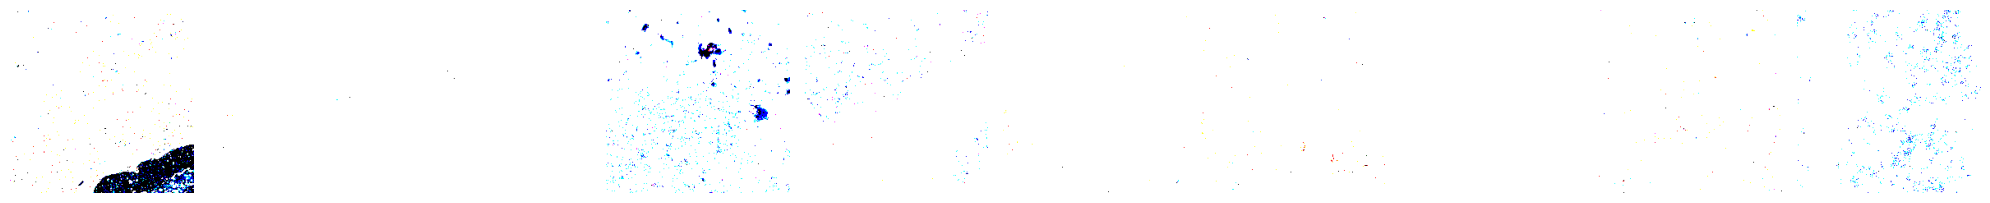

Epoch 1/50
46/46 - 184s - loss: 0.4727 - accuracy: 0.9191 - val_loss: 0.5317 - val_accuracy: 0.8813 - 184s/epoch - 4s/step
Epoch 2/50
46/46 - 218s - loss: 0.0881 - accuracy: 0.9834 - val_loss: 0.4218 - val_accuracy: 0.8938 - 218s/epoch - 5s/step
Epoch 3/50
46/46 - 225s - loss: 0.0429 - accuracy: 0.9889 - val_loss: 0.2482 - val_accuracy: 0.9563 - 225s/epoch - 5s/step
Epoch 4/50
46/46 - 228s - loss: 0.0172 - accuracy: 0.9959 - val_loss: 0.4639 - val_accuracy: 0.9438 - 228s/epoch - 5s/step
Epoch 5/50
46/46 - 241s - loss: 0.0104 - accuracy: 0.9952 - val_loss: 0.4232 - val_accuracy: 0.9250 - 241s/epoch - 5s/step
Epoch 6/50
46/46 - 240s - loss: 0.0124 - accuracy: 0.9965 - val_loss: 0.5828 - val_accuracy: 0.9375 - 240s/epoch - 5s/step
Epoch 7/50
46/46 - 201s - loss: 0.0302 - accuracy: 0.9924 - val_loss: 0.2707 - val_accuracy: 0.9625 - 201s/epoch - 4s/step
Epoch 8/50
46/46 - 228s - loss: 0.0016 - accuracy: 0.9993 - val_loss: 0.1726 - val_accuracy: 0.9625 - 228s/epoch - 5s/step
Epoch 9/50
46/46

/Users/varnarajnaguleswaran/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


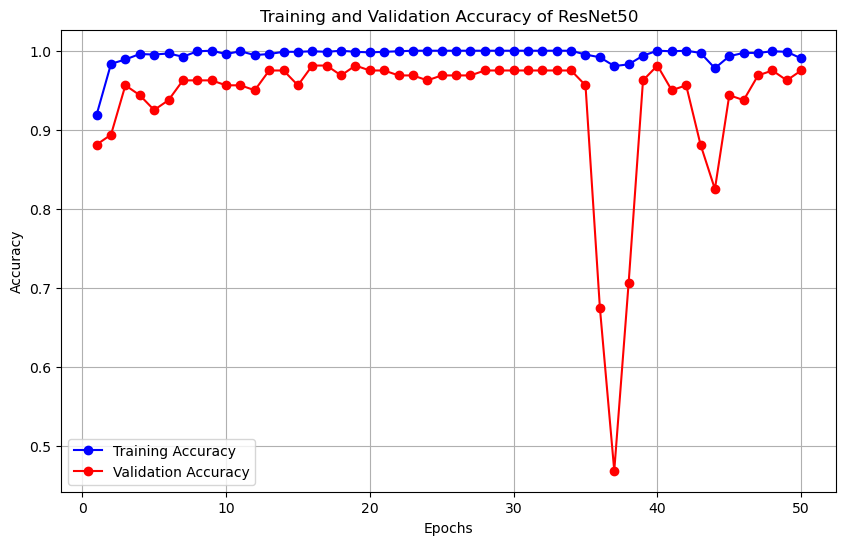

15/15 [==============================] - 10s 664ms/step - loss: 0.2505 - accuracy: 0.9500
Testing Accuracy: 0.949999988079071
15/15 - 10s - 10s/epoch - 675ms/step
Confusion matrix, without normalization
[[137   8]
 [  4  91]]


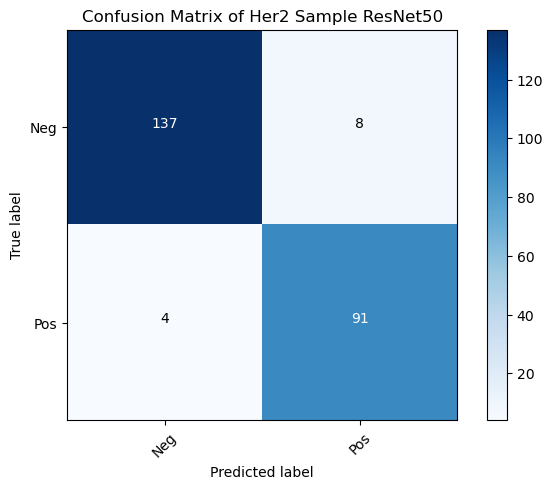

In [2]:
#!/usr/bin/env python
# coding: utf-8

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import itertools
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams["axes.grid"] = False

base = "/Users/varnarajnaguleswaran/Downloads/Her2 - 2classesv02"

train_path = os.path.join(base, 'Train')
test_path = os.path.join(base, 'Test')

classes = os.listdir(train_path)[1:]

dataGenerator = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input, validation_split=0.1)
train_batches = dataGenerator.flow_from_directory(directory=train_path, target_size=(224, 224), classes=classes, batch_size=32, class_mode='categorical', subset='training')
valid_batches = dataGenerator.flow_from_directory(directory=train_path, target_size=(224, 224), classes=classes, batch_size=16, class_mode='categorical', subset='validation')
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input).flow_from_directory(directory=test_path, target_size=(224, 224), classes=classes, batch_size=16, shuffle=False, class_mode='categorical', subset='training')


def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

imgs, labels = next(train_batches)

plotImages(imgs)

resnet50_model = tf.keras.applications.ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

model = Sequential()
model.add(resnet50_model)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=2, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x=train_batches, validation_data=valid_batches, epochs=50, verbose=2)

model.save(base + "FT_HER2Sample_ResNet50.h5")

# Extract training and validation accuracy
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Create a range of epochs
epochs = range(1, 51)

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy of ResNet50')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

test_loss, test_accuracy = model.evaluate(test_batches)

print("Testing Accuracy:", test_accuracy)

predictions = model.predict(x=test_batches, verbose=2)
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))


def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    print(cm)
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


plot_confusion_matrix(cm=cm, classes=classes, title='Confusion Matrix of Her2 Sample ResNet50')


1/1 [==============================] - 0s 150ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 269ms/step


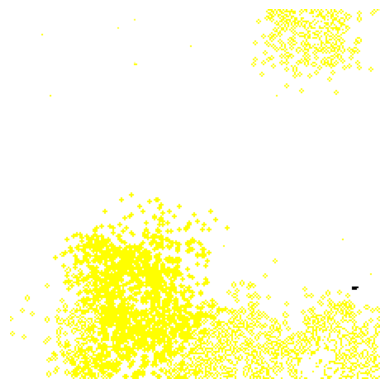

In [8]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Create a Lime explainer for image classification
explainer = lime_image.LimeImageExplainer()

# Choose an image from your test dataset for explanation
# image_path = "path/to/your/image.jpg"
image_path = "/Users/varnarajnaguleswaran/Downloads/Her2 - 2classesv02/Test/Neg/03918_train_0.png"

image = PIL.Image.open(image_path)

# Resize the image to the expected input shape (224, 224)
image = image.resize((224, 224))

# Preprocess the image for the ResNet50 model
preprocessed_image = tf.keras.applications.resnet.preprocess_input(np.array(image))

# Predict the class probabilities for the image using your model
class_probabilities = model.predict(np.expand_dims(preprocessed_image, axis=0))

# Define the class index you want to explain (0 or 1 in your case)
class_index_to_explain = 1  # Change this to the desired class index

# Generate an explanation for the prediction
explanation = explainer.explain_instance(preprocessed_image, model.predict, top_labels=2, num_samples=1000)

# Get the explanation for the class of interest
explanation_for_class = explanation.top_labels[class_index_to_explain]

# Visualize the explanation
explanation_image, mask = explanation.get_image_and_mask(class_index_to_explain, positive_only=False, num_features=5, hide_rest=False)

# Plot the original image with the explanation
plt.imshow(mark_boundaries(explanation_image / 2 + 0.5, mask))
plt.axis('off')
plt.show()


1/1 [==============================] - 0s 101ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 260ms/step


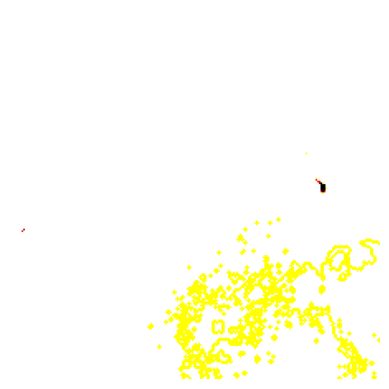

1/1 [==============================] - 0s 149ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 271ms/step


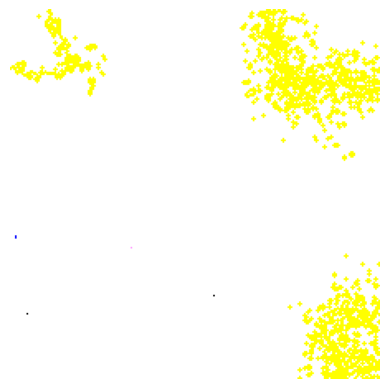

1/1 [==============================] - 0s 164ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 267ms/step


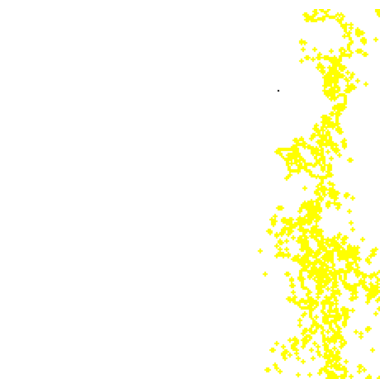

1/1 [==============================] - 0s 141ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 274ms/step


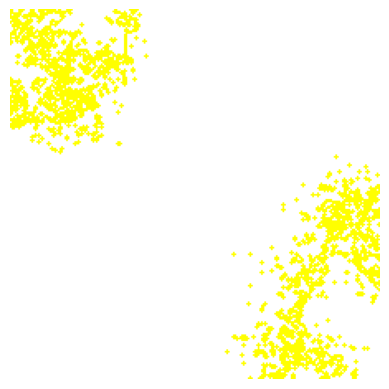

1/1 [==============================] - 0s 116ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 271ms/step


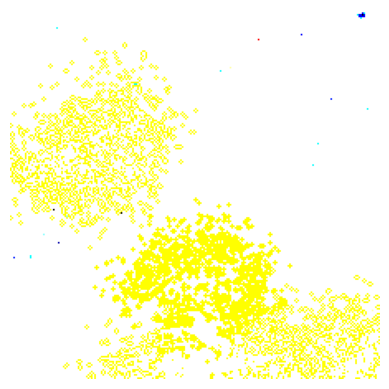

1/1 [==============================] - 0s 115ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 280ms/step


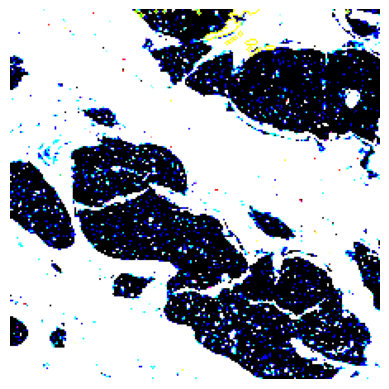

1/1 [==============================] - 0s 187ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 299ms/step


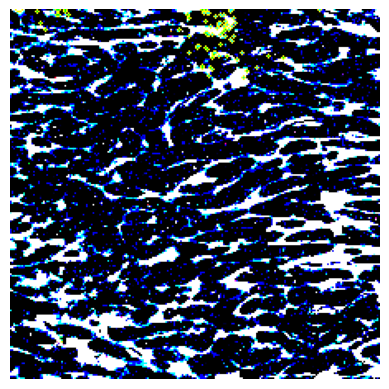

1/1 [==============================] - 0s 152ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 301ms/step


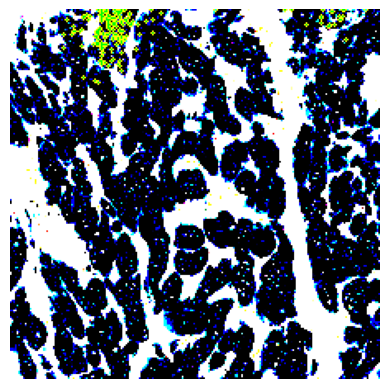

1/1 [==============================] - 0s 187ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 284ms/step


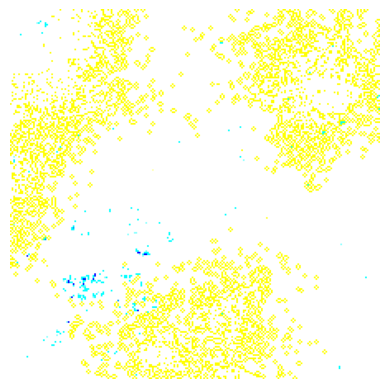

1/1 [==============================] - 0s 114ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 283ms/step


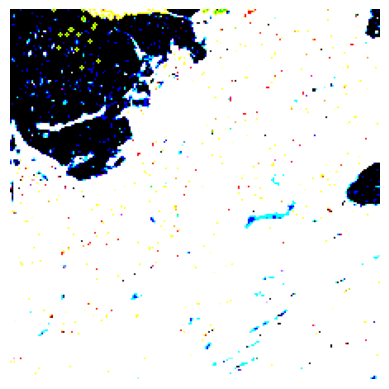

In [9]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Create a Lime explainer for image classification
explainer = lime_image.LimeImageExplainer()

# List of image paths
image_paths = [
    "/Users/varnarajnaguleswaran/Downloads/Her2 - 2classesv02/Test/Neg/03920_train_1+.png",
    "/Users/varnarajnaguleswaran/Downloads/Her2 - 2classesv02/Test/Neg/03903_train_1+.png",
    "/Users/varnarajnaguleswaran/Downloads/Her2 - 2classesv02/Test/Neg/03804_train_1+.png",
    "/Users/varnarajnaguleswaran/Downloads/Her2 - 2classesv02/Test/Neg/03705_train_1+.png",
    "/Users/varnarajnaguleswaran/Downloads/Her2 - 2classesv02/Test/Neg/03579_train_1+.png",
    "/Users/varnarajnaguleswaran/Downloads/Her2 - 2classesv02/Test/Pos/02110_train_3+.png",
    "/Users/varnarajnaguleswaran/Downloads/Her2 - 2classesv02/Test/Pos/02296_train_3+.png",
    "/Users/varnarajnaguleswaran/Downloads/Her2 - 2classesv02/Test/Pos/02536_train_3+.png",
    "/Users/varnarajnaguleswaran/Downloads/Her2 - 2classesv02/Test/Pos/01997_train_3+.png",
    "/Users/varnarajnaguleswaran/Downloads/Her2 - 2classesv02/Test/Pos/01751_train_3+.png",
]

# Loop through each image
for image_path in image_paths:
    # Load the image
    image = PIL.Image.open(image_path)

    # Resize the image to the expected input shape (224, 224)
    image = image.resize((224, 224))

    # Preprocess the image for the ResNet50 model
    preprocessed_image = tf.keras.applications.resnet.preprocess_input(np.array(image))

    # Predict the class probabilities for the image using your model
    class_probabilities = model.predict(np.expand_dims(preprocessed_image, axis=0))

    # Define the class index you want to explain (0 or 1 in your case)
    class_index_to_explain = 1  # Change this to the desired class index

    # Generate an explanation for the prediction
    explanation = explainer.explain_instance(preprocessed_image, model.predict, top_labels=2, num_samples=1000)

    # Get the explanation for the class of interest
    explanation_for_class = explanation.top_labels[class_index_to_explain]

    # Visualize the explanation
    explanation_image, mask = explanation.get_image_and_mask(class_index_to_explain, positive_only=False, num_features=5, hide_rest=False)

    # Plot the original image with the explanation
    plt.imshow(mark_boundaries(explanation_image / 2 + 0.5, mask))
    plt.axis('off')
    plt.show()
